In [87]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import pandas as pd
from scipy.integrate import quad_vec, cumulative_trapezoid
from scipy.special import spherical_jn
from collections.abc import Iterable
from aidm.const import *
from astropy.table import Table

## set fig params|
sns.set_context("paper")
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {
        'text.latex.preamble': [r'\usepackage{amsmath}', r'\boldmath'],
        'text.usetex':True,
        'axes.labelsize':20.,
        'xtick.labelsize':16,
        'ytick.labelsize':16,
        'figure.figsize':[10., 8.],
        'font.family':'DejaVu Sans',
        'legend.fontsize':18}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline


u.set_enabled_equivalencies(u.mass_energy())

/usr/local/Cellar/python@3.9/3.9.2_4/Frameworks/Python.framework/Versions/3.9/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [88]:
RECALC_LIMITS = False

In [89]:
exps = ['GDM', 'MAQRO', 'Pino', None, 'BECCAL']

In [90]:
data_dir = '../data/'

## load 5th force constraints + define conversion to sigma_n
ffmphi, ffyn = np.loadtxt(data_dir+'Force5thynVSmPhiGeV.dat', unpack=True)
ffmphi = (ffmphi*u.GeV).to(u.MeV)


def yn_to_sigman(yn, mx, mphi, yx=1, mux=None, vdm=vdm):
    if mux == None:
        mux = mx
    massfac = mux**2/(mphi**2+vdm**2*mx**2)**2
    sig_in_invGeV = (yn**2 * yx**2 * massfac * 1. / (4 * np.pi)).to(1./u.GeV**2)
    return (sig_in_invGeV*1./lp**2).to(u.cm**(2))


## load other constraints
HeNRdat = pd.read_csv(data_dir+'NR.txt', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')
Hephodat = pd.read_csv(data_dir+'phonon2.txt', names=['mx', 'sigma'], delimiter='\s+').sort_values(by='mx')


## self-interaction constraints
def sigma_self(mx, mphi, gstar=10):
    return (1.55e-24*u.cm**2*(mphi/mx)**4*(gstar/10)**(0.5)*(u.GeV/mx)).to(u.cm**2)

In [99]:
def plot_diagram_subplot():
    qdeltax = np.logspace(-3,3,2000)
    plt.figure(figsize=(10,6))
    plt.semilogx(qdeltax, 1-np.sin(qdeltax)/qdeltax, lw=2)
    plt.xlabel(r'$q\Delta x$')
    plt.ylabel(r'$\rm{Decoherence~Effect}$')

In [62]:
def plot_exp(ax, exp, qmin=True, mphi_ratios=1.e-5, medtype='light'):
    if RECALC_LIMITS:
        get_lim(exp, qmin=qmin, mphi_ratios=mphi_ratios, medtype=medtype)
    ## load data
    try:
        fn = f'../results/limits/{exp}_{qmin}_{medtype[0]}.dat'
        dat = Table.read(fn, format='ascii.ecsv')
        dat[f'sigma_{int(-1.*np.log10(mphi_ratios))}']
    except KeyError:
        print("Can't find column. Looking for single mphi version.")
        fn = f'../results/limits/{exp}_{qmin}_{medtype[0]}_{int(-1.*np.log10(mphi_ratios))}.dat'
        dat = Table.read(fn, format='ascii.ecsv')
    except (IOSError, OSError):
        print("Can't find file. Re-running limits.")
        get_lim(exp, qmin=qmin, mphi_ratios=mphi_ratios, medtype=medtype)
        fn = f'../results/limits/{exp}_{qmin}_{medtype[0]}_{int(-1.*np.log10(mphi_ratios))}.dat'
        dat = Table.read(fn, format='ascii.ecsv')
    if qmin:
        ls = 'solid'
        label = f'$\\rm{{{exp}}}$'
    else:
        ls = 'dashed'
        label = None
    ax.loglog(dat['mx'], dat[f'sigma_{int(-1.*np.log10(mphi_ratios))}'], lw=2, c=cs[exps.index(exp)], ls=ls, label=label)

In [63]:
def plot_specific_mphi(mpr, plot_noqmin=True):
    f, ax = plt.subplots(1,1, figsize=(10,6))

    for ex in exps:
        if ex == None:
            continue
        plot_exp(ax, ex)
        if plot_noqmin:
            plot_exp(ax, ex, qmin=False)
    ## text indicating mediator mass
    plt.text(0.15, 0.05,f'$m_{{\phi}} = 10^{{{int(np.log10(mpr))}}}m_{{\chi}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)

    ## plot other limits
    ## self-interaction
    plt.loglog(ffmphi*1./mpr, sigma_self(ffmphi*1./mpr, ffmphi), color='k')
    plt.fill_between(ffmphi*1./mpr, sigma_self(ffmphi*1./mpr, ffmphi), 1, color='k', alpha=0.3, hatch='X')
    ffsigma = yn_to_sigman(ffyn, ffmphi*1./mpr, ffmphi)
    plt.loglog(ffmphi*1./mpr, ffsigma, color='k')
    plt.fill_between(ffmphi*1./mpr, ffsigma, 1., color='k', alpha=0.3)

    plt.loglog(10**HeNRdat['mx'], 10**HeNRdat['sigma'], color='black', alpha=0.5)
    plt.text(3, 1.e-43, 'He NR', color='gray', rotation=-20)
    plt.loglog(10**Hephodat['mx'], 10**Hephodat['sigma'], color='black', alpha=0.5, ls='dashed')
    plt.text(1.e-1, 9.e-44, 'He 2-phonon', color='gray', rotation=-42)

    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel(r'$m_{\chi}~[\rm{MeV}]$');
    plt.ylabel(r'$\bar{\sigma}_n~[\rm{cm}^2]$');
    plt.xlim([1.e-9, 1.e3])
    plt.ylim([1.e-45, 1.e-20])

    plt.savefig(f'../results/reach_plot_{int(-1.*np.log10(mpr))}.pdf')

In [64]:
def plot_panel(ax, mpr, asym=False, legend=False):
    for ex in exps:
        if ex == None:
            continue
        plot_exp(ax, ex)
    ## text indicating mediator mass
    ax.text(0.15, 0.05,f'$m_{{\phi}} = 10^{{{int(np.log10(mpr))}}}m_{{\chi}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)
    
    ## text indicating asymmetric dm
    if asym:
        ax.text(0.17, 0.12, r'$\rm{Asymmetric~DM}$', 
                horizontalalignment='center', verticalalignment='center',
                transform = ax.transAxes,fontsize=16)

    ## plot other limits
    ## self-interaction
    if not asym:
        ax.loglog(ffmphi*1./mpr, sigma_self(ffmphi*1./mpr, ffmphi), color='k')
        ax.fill_between(ffmphi*1./mpr, sigma_self(ffmphi*1./mpr, ffmphi), 1, color='k', alpha=0.3, hatch='X')
    ffsigma = yn_to_sigman(ffyn, ffmphi*1./mpr, ffmphi)
    ax.loglog(ffmphi*1./mpr, ffsigma, color='k')
    ax.fill_between(ffmphi*1./mpr, ffsigma, 1., color='k', alpha=0.3)

    ax.loglog(10**HeNRdat['mx'], 10**HeNRdat['sigma'], color='black', alpha=0.5)
    ax.text(3, 1.e-43, 'He NR', color='gray', rotation=-20)
    ax.loglog(10**Hephodat['mx'], 10**Hephodat['sigma'], color='black', alpha=0.5, ls='dashed')
    ax.text(1.e-1, 9.e-44, 'He 2-phonon', color='gray', rotation=-42)

    if legend:
        ax.legend(loc='upper left', fontsize=15)
    ax.set_xlabel(r'$m_{\chi}~[\rm{MeV}]$');
    ax.set_ylabel(r'$\bar{\sigma}_n~[\rm{cm}^2]$');
    ax.set_xlim([1.e-9, 1.e3])
    ax.set_ylim([1.e-45, 1.e-20])

In [65]:
def plot_four_panel():
    f, ax = plt.subplots(2,2, figsize=(15,10))
    plot_panel(ax[0,0], 1.e-5, legend=True)
    plot_panel(ax[0,1], 1.e-5, asym=True)
    plot_panel(ax[1,0], 1.e-2)
    plot_panel(ax[1,1], 1.e-2, asym=True)
    f.tight_layout()
    plt.savefig(f'../results/reach_plot.pdf')

In [66]:
def plot_qmin_noqmin(mpr=1.e-2):
    f, ax = plt.subplots(1,1, figsize=(10,6))

    for ex in exps:
        if ex == None:
            continue
        plot_exp(ax, ex)
        plot_exp(ax, ex, qmin=False)
    ## text indicating mediator mass
    plt.text(0.15, 0.05,f'$m_{{\phi}} = 10^{{{int(np.log10(mpr))}}}m_{{\chi}}$',
             horizontalalignment='center', verticalalignment='center', 
             transform = ax.transAxes,fontsize=16)

    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel(r'$m_{\chi}~[\rm{MeV}]$');
    plt.ylabel(r'$\bar{\sigma}_n~[\rm{cm}^2]$');
    plt.xlim([1.e-9, 1.e3])
    plt.ylim([1.e-45, 1.e-20])

    plt.savefig(f'../results/qmin_comp.pdf')

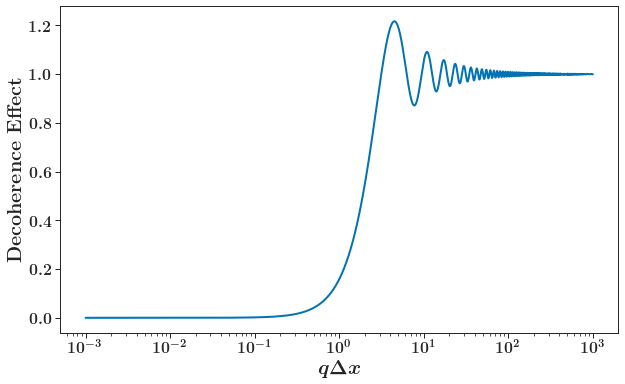

In [101]:
plot_diagram_subplot()

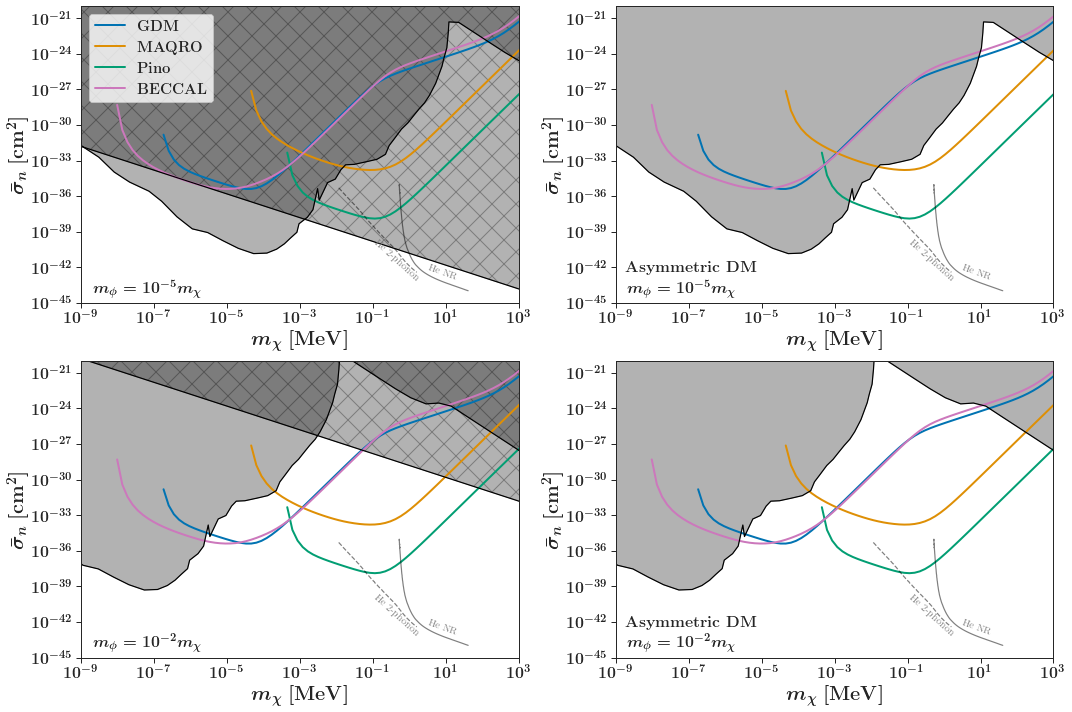

In [67]:
plot_four_panel()

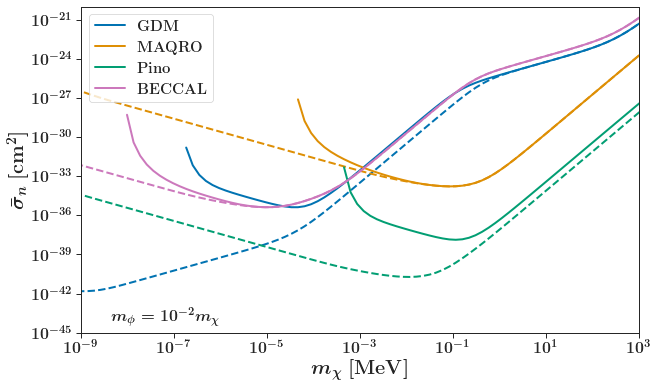

In [68]:
plot_qmin_noqmin()